##**<center>Facial Emotions Recognition System</center>**##

###<b>Phase 1: Pre-Processing</b>

####1.1 Mounting Google Drive####

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####1.2 Extracting the Dataset####

In [ ]:
import zipfile

dataset_path = '/content/drive/MyDrive/IMAGES/FER-2103.zip'
images_count = 0
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    images_count  = images_count + 1
    zip_ref.printdir()
    print('Extracting all the files now...')
    zip_ref.extractall('/content/drive/MyDrive/IMAGES')
  
print("Extracted images from dataset")

####1.3 Checking whether the Drive accesed properly. BY Displaying a sample Image ####

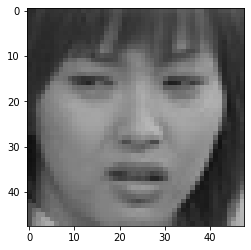

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("/content/drive/MyDrive/IMAGES/IMAGES_FEC/train/1/1073.jpg") 
plt.imshow(img)

####1.4 Reading all the Images and Converting it into a list and saving the read data into a pickle file ####

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import os

dataDirectory = "/content/drive/MyDrive/IMAGES/IMAGES_FEC/train" 
classes = ["0","1","2","3","4","5","6"] 
# 0-angry 1-disgust 2-fear 3-happy 4-neutral 5-sad 6-surprise
#classes = ["angry", "disgust","fear","happy","neutral", "sad", "surprise"]
img_size = 224 ## Imagenet --> 224 x 224

image_data = [] #data list

# Function to create training data
def prepare_training_data():
    for category in classes:
        path = os.path.join(dataDirectory , category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path , img))
                resized_img = cv2.resize(img_array, (img_size,img_size))
                image_data.append([resized_img, class_num])
                c= c+1
            except Exception as e:
                    pass
                    
    file_name = "sample_image_data.pkl"
    file_pointer = open(file_name, "wb")
    pickle.dump(image_data, file_pointer)
    file_pointer.close()

In [ ]:
prepare_training_data()

###<b>Phase 2: Face Dectection</b>

####2.1 Incoporating Face Detection Algorithm ####

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

faceCascade = cv2.CascadeClassifier('/content/drive/MyDrive/IMAGES/IMAGES_FEC/facedetection_algorithm.xml')

####2.2 Checking Face Detection using a Sample Image ####

In [ ]:
sample_img = cv2.imread('/content/drive/MyDrive/angry_test.jpg')
gray = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY) #BGR to GRAY color
gray.shape

(187, 269)

In [ ]:
faces = faceCascade.detectMultiScale(gray, 1.1, 4)
for x,y,w,h in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = sample_img[y:y+h, x:x+w]
    cv2.rectangle(sample_img, (x,y), (x+w ,y+h), (255,0,0,0), 2)
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(facess) == 0:
        print("face not detected")
    else:
        for (ex,ey,ew,eh) in facess:
            face_roi = roi_color[ey: ey+eh, ex:ex+ew]

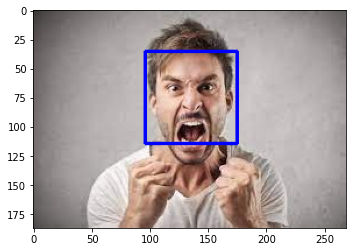

In [ ]:
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

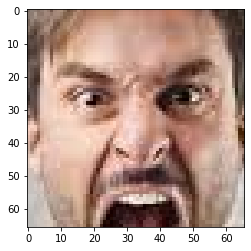

In [ ]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

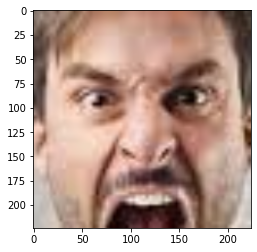

In [ ]:
final_image = cv2.resize(face_roi, (224, 224))
final_image = cv2.cvtColor(final_image,cv2.COLOR_BGR2RGB)
plt.imshow(final_image)
final_image = np.expand_dims(final_image, axis = 0)#need 4th dimensions

###<b>Phase 3: Feature Extraction and Model Creation</b>

####3.1 Open Image data in PKL file ####

In [ ]:
training_data = []
file_name = "/content/sample_image_data.pkl"
open_file = open(file_name, "rb")
training_data = pickle.load(open_file)
open_file.close()

print("Total Training Image:", len(training_data))

Total Training Image: 28


####3.2 Shuffle the training data for effective results  ####

In [ ]:
import random 
random.shuffle(training_data) #for making the model more dynamic

####3.3 Creating X and Y numpy arrays for Training Model  ####

In [ ]:

X = [] #data
Y = [] #label of emotion

for data,label in training_data:
    X.append(data)
    Y.append(label)
    
X = np.array(X).reshape(-1, img_size ,img_size , 3) #we need 4 dimesions
Y = np.array(Y)

In [ ]:
# X = X/255.0   # normalizing the data

In [ ]:
print(X.shape)
print(Y.shape)

(28, 224, 224, 3)
(28,)


####3.3 Transfer Learning from MobileNetV2 (pre-trained model)  ####

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# MobileNet-v2 is a convolutional neural network that is 53 layers deep.
# This network trained on more than a million images from the ImageNet database
# The pretrained network can classify images into 1000 object categories,
model = tf.keras.applications.MobileNetV2()  #pre-trained model
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

####3.4 Defining Input, Output Layers and Adding new layers to classify upto 7 emotions   ####

In [ ]:
base_input = model.layers[0].input #input to our model
base_output = model.layers[-2].output #output to our model

In [ ]:
print(base_input)
print(base_output)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1280), dtype=tf.float32, name=None), name='global_average_pooling2d/Mean:0', description="created by layer 'global_average_pooling2d'")


In [ ]:
final_output = layers.Dense(128)(base_output)  #adding new layer, after the output of global pooling layer
final_output = layers.Activation('relu')(final_output) #activation function
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation ='softmax')(final_output) #we are classifing 7 classes
print(final_output)

KerasTensor(type_spec=TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), name='dense_2/Softmax:0', description="created by layer 'dense_2'")


In [ ]:
fer_model = keras.Model(inputs = base_input , outputs = final_output)
fer_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
fer_model.compile(loss = "sparse_categorical_crossentropy" ,optimizer ="adam", metrics =["accuracy"])

#### **3.5 Traning the Model**   ####

In [ ]:
fer_model.fit(X,Y , epochs = 3)

Epoch 1/3
1/1 [==============================] - 11s 11s/step - loss: 2.2087 - accuracy: 0.1429
Epoch 2/3
1/1 [==============================] - 5s 5s/step - loss: 0.7266 - accuracy: 0.9286
Epoch 3/3
1/1 [==============================] - 5s 5s/step - loss: 0.1511 - accuracy: 1.0000


####3.6 Saving the trained Model 


In [ ]:
fer_model.save('FES_Model_1.h5')

NameError: ignored

###<b>Phase 4: Expression Classification</b>

####4.1 Loading the saved Model 


In [ ]:
#Hierarchical Data Format 5. It is an open-source file which comes in handy to store large amount of data
fer_model = tf.keras.models.load_model('/content/drive/MyDrive/IMAGES/IMAGES_FEC/pro_model_full_50epoch_v1.h5') 

####4.2 Preparing with a sample image####

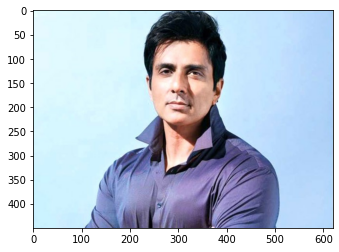

In [ ]:
faceCascade = cv2.CascadeClassifier('/content/drive/MyDrive/IMAGES/IMAGES_FEC/facedetection_algorithm.xml')

path = "/content/drive/MyDrive/neutral_test.jpeg"
sample_img = cv2.imread(path)

#cv2. cvtColor() method is used to convert an image from one color space to another
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

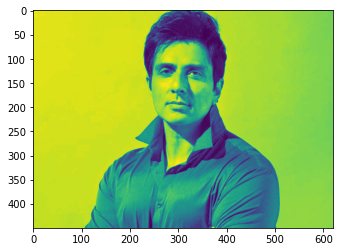

In [ ]:
gray_image = cv2.cvtColor(sample_img , cv2.COLOR_BGR2GRAY) #BGR to GRAY color
plt.imshow(gray_image)

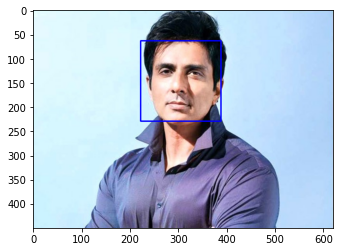

In [ ]:
faces = faceCascade.detectMultiScale(gray_image, 1.1,4)
for x,y,w,h in faces:
    roi_gray = gray_image[y:y+h, x:x+w]
    roi_color = sample_img[y:y+h, x:x+w]
    cv2.rectangle(sample_img, (x,y), (x+w ,y+h), (255,0,0,0), 2)
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(facess) ==0:
        print("face not detected")
    else:
        for (ex,ey,ew,eh) in facess:
            face_roi = roi_color[ey: ey+eh, ex:ex+ew]
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

In [ ]:
import numpy as np

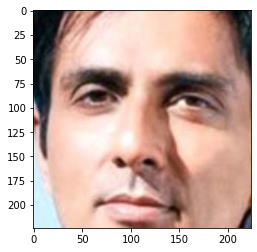

In [ ]:
final_image = cv2.resize(face_roi, (224,224))
final_image = cv2.cvtColor(final_image , cv2.COLOR_BGR2RGB)
plt.imshow(final_image)
final_image = np.expand_dims(final_image, axis =0)#need 4th dimensions

####4.3 Applying Prediction ####



In [ ]:
prediction = fer_model.predict(final_image)

In [ ]:
prediction[0]


array([6.5870535e-13, 1.1966771e-18, 3.1373020e-09, 1.5671703e-16,
       1.0000000e+00, 1.7447865e-09, 1.1173579e-09], dtype=float32)

In [ ]:
result = np.argmax(prediction)



print("The Person in the image is mostly likely to be in ", end = "")
if(result == 0):
    print("Angry")
elif(result == 1):
    print("Disgust")
elif(result == 2):
    print("Fear")
elif(result == 3):
    print("Happy")
elif(result == 4):
    print("Neutral")
elif(result == 5):
    print("Sad")
elif(result == 6):
    print("Surprise")

The Person in the image is mostly likely to be in Neutral


###<b>Testing and Evaluation</b>

In [ ]:
test_data = []
file_name = "/content/drive/MyDrive/IMAGES/IMAGES_FEC/image_data3.pkl"

open_file = open(file_name, "rb")
test_data = pickle.load(open_file)
open_file.close()

print("Testing Images: ",len(test_data))

Testing Images:  21257


In [ ]:
import random 
random.shuffle(test_data) #for making the model more dynamic

x_test = []
y_test = []

for data,label in test_data:
    x_test.append(data)
    y_test.append(label)

x_test = np.array(x_test).reshape(-1, img_size ,img_size ,3)
y_test = np.array(y_test)

print(x_test.shape)
print(y_test.shape)

(21257, 224, 224, 3)
(21257,)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#Hierarchical Data Format 5. It is an open-source file which comes in handy to store large amount of data
new_model = tf.keras.models.load_model('/content/drive/MyDrive/IMAGES/IMAGES_FEC/pro_model_full_50epoch_v1.h5') 

In [ ]:
new_model.evaluate(x_test, y_test, verbose = 0)

[0.09493813663721085, 0.9692336916923523]

###<b>Final Result and Applications Demo of the Project</b>

####**Application 1**: Remote Class Student Emotional Review during class


#### 1.1 Extracting an Image for each 5 seconds from a Web Cam recording of a student during Online Lecture


In [ ]:
import cv2
time = 0
count = 0

cap = cv2.VideoCapture('/content/drive/MyDrive/IMAGES/IMAGES_FEC/myvedio.mp4')

while True:
    try:
        time = time + 2500
        count = count + 1 
        cap.set(cv2.CAP_PROP_POS_MSEC,time)
        ret,frame = cap.read()                  # Retrieves the frame at the specified second
        cv2.imwrite('/content/drive/MyDrive/IMAGES/IMAGES_FEC/Video_Images/'+str(count)+'.jpg', frame)
    except Exception as e:
        break

print("Extracted ", count, " images from vedio")

Extracted  15  images from vedio


#### 1.2 Applying prediction on all Images extracted


In [ ]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

#Hierarchical Data Format 5. It is an open-source file which comes in handy to store large amount of data
fer_model = tf.keras.models.load_model('/content/drive/MyDrive/IMAGES/IMAGES_FEC/pro_model_full_50epoch_v1.h5') 

faceCascade = cv2.CascadeClassifier('/content/drive/MyDrive/IMAGES/IMAGES_FEC/facedetection_algorithm.xml')

path = "/content/drive/MyDrive/IMAGES/IMAGES_FEC/Video_Images/"


Emotions = [0,0,0,0,0,0,0]

pic_count = 0

for img in os.listdir(path):
            try:
                sample_img = cv2.imread(os.path.join(path , img))
                gray_image = cv2.cvtColor(sample_img , cv2.COLOR_BGR2GRAY) #BGR to GRAY color
                
                faces = faceCascade.detectMultiScale(gray_image, 1.1,4)
                for x,y,w,h in faces:
                    roi_gray = gray_image[y:y+h, x:x+w]
                    roi_color = sample_img[y:y+h, x:x+w]
                    cv2.rectangle(sample_img, (x,y), (x+w ,y+h), (255,0,0,0), 2)
                    facess = faceCascade.detectMultiScale(roi_gray)
                    if len(facess) ==0:
                        print("face not detected")
                    else:
                        for (ex,ey,ew,eh) in facess:
                            face_roi = roi_color[ey: ey+eh, ex:ex+ew]
                final_image = cv2.resize(face_roi, (224,224))
                final_image = np.expand_dims(final_image, axis =0)
                prediction = fer_model.predict(final_image)
                result = np.argmax(prediction)
                pic_count = pic_count + 1
                #print("The Person in the image is mostly likely to be in ", end = "")
                if(result == 0):
                    Emotions[0] = Emotions[0] + 1
                    #print("Angry")
                elif(result == 1):
                    Emotions[1] = Emotions[1] + 1
                    #print("Disgust")
                elif(result == 2):
                    Emotions[2] = Emotions[2] + 1
                    #print("Fear")
                elif(result == 3):
                    Emotions[3] = Emotions[3] + 1
                    #print("Happy")
                elif(result == 4):
                    Emotions[4] = Emotions[4] + 1
                    #print("Neutral")
                elif(result == 5):
                    Emotions[5] = Emotions[5] + 1
                    #print("Sad")
                elif(result == 6):
                    Emotions[6] = Emotions[6] + 1
                    #print("Surprise")
            except Exception as e:
                pass
print(Emotions)

[0, 0, 0, 0, 0, 0, 0]


#### 1.3 Visualization of the Results


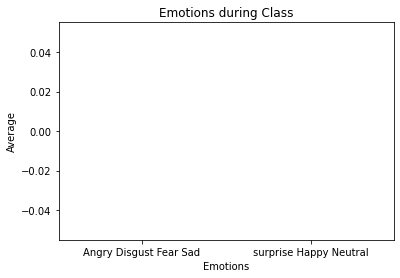

In [ ]:
#classes = ["angry", "disgust","fear","happy","neutral", "sad", "surprise"]

emotion = [(Emotions[0] + Emotions[1] + Emotions[2] + Emotions[5]) / 4,  (Emotions[3] + Emotions[4] + Emotions[6])/3]
typ = ['Angry Disgust Fear Sad', 'surprise Happy Neutral']


plt.bar(typ,emotion)
plt.title('Emotions during Class')
plt.xlabel("Emotions")
plt.ylabel('Average')
plt.show()

####**Application 2**: Facial Emotion recognition using Web Cam

#### 2.1: Google Colab: Access Webcam for Images and Video

For this purpose of this tutorial we will be using OpenCV's Haar Cascade to do face detection on our Webcam image and video.

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


#### 2.2 Helper Functions
Below are a few helper function to make converting between different image data types and formats. 

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

####2.3 Webcam Videos



Running code on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our progam (face detection) and create an overlay image that contains bounding box of detection(s). We then overlay the bounding box image back onto the next frame of our video stream.

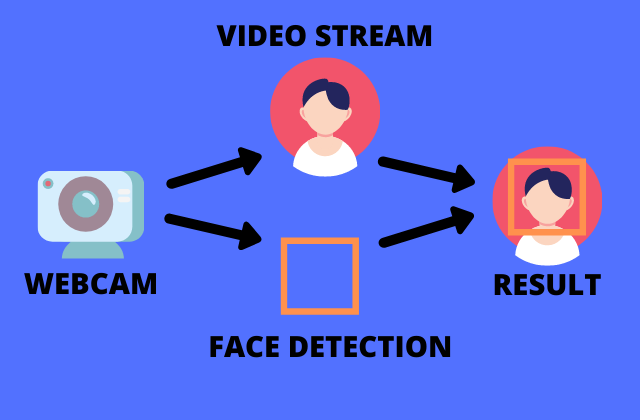</center>

#### 2.4 Web Cam Stream Function


In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

#### 2.5 Initializing Web Stream and Applying Predicition using Model


In [ ]:
# initialize the Haar Cascade face detection model
faceCascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

# start streaming video from webcam
video_stream()

# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = faceCascade.detectMultiScale(gray)

    # get face bounding box for overlay
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        facess = faceCascade.detectMultiScale(roi_gray)
        if len(facess) == 0:
            print("Face not detected")
        else:
            for (ex, ey, ew, eh) in facess:
                face_roi = roi_color[ey: ey+eh, ex:ex + ew]

        final_image = cv2.resize(face_roi, (224, 224))
        final_image = np.expand_dims(final_image, axis =0) ## need fourth dimension

        #Hierarchical Data Format 5. It is an open-source file which comes in handy to store large amount of data
        new_model = tf.keras.models.load_model('/content/drive/MyDrive/Mini_Project/pro_model_v1.h5')    

        font = cv2. FONT_HERSHEY_SIMPLEX
        Predictions = new_model.predict(final_image)
        font_scale = 1.5
        font = cv2.FONT_HERSHEY_PLAIN
        if (np.argmax(Predictions) == 0):
            status = "Angry"
        elif (np.argmax (Predictions) == 1):
            status = "Disgust"
        elif (np.argmax(Predictions) == 2):
            status = "Fear"
        elif (np.argmax(Predictions) == 3):
            status = "Happy"
        elif (np.argmax(Predictions) == 4):
            status = "Neutral"
        elif (np.argmax(Predictions) == 5):
            status = "Sad"
        elif (np.argmax(Predictions) == 6):
            status = "Surprise"

        bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
    

    js_reply = video_frame(status, bbox)
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

Face not detected
Face not detected
Face not detected
Face not detected
